# <span style="color:orange"> Monoasset test: Pricing Geometric Average Asian Option </span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pricing import DiscountingCurve, EquityForwardCurve, Black, Vanilla_PayOff,ForwardVariance
from montecarlo import MC_Analisys, MC
import time, sys
import lets_be_rational.LetsBeRational as lbr
from matplotlib import ticker
from scipy.stats.mstats import gmean
from closedforms import GA_Asian_option_closed_form, European_option_closed_form, volatility_asian, interest_rate_asian
from numpy import log, sqrt, exp

### Parameters of Simulation

In [13]:
t = 0
spot_price = 150
N_simulations = 5e5
N_block = 100
N_averages = 30
T_max = 10
maturity = 4.
dates = np.linspace(0.,maturity,N_averages)
r = 1./100
volatility = 50./100
asian_vola = volatility_asian(N_averages,volatility)

### Market Data


zero interest rate time grid [ 0.  5. 10.]
zero interest rate:  [0.01 0.01 0.01]


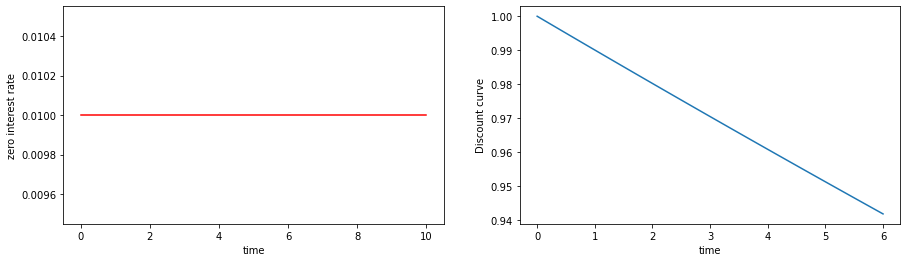

In [5]:
"""Discounut Factors"""
zero_interest_rate = np.array([r,r,r])
zero_interest_rate_dates = np.array([0.0,5,T_max])
d = exp(-zero_interest_rate*zero_interest_rate_dates)        #market discount factors 
D = DiscountingCurve(reference=t, discounts=d, dates=zero_interest_rate_dates)   #discounting curve

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.step(zero_interest_rate_dates, D.r(zero_interest_rate_dates), color="red")
plt.xlabel("time")
plt.ylabel("zero interest rate")

plt.subplot(1,2,2)
x = np.linspace(0.,6,100)
plt.plot(x,D(x))
plt.xlabel("time")
plt.ylabel("Discount curve")
plt.show()

Forward repo time grid [ 0. 10.]
Forward repo rate:  [0. 0.]


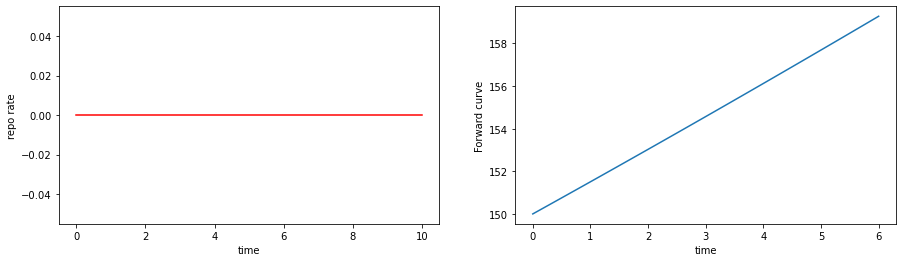

In [6]:
"""Forward curve and repo rates"""
F = EquityForwardCurve(reference=t, discounting_curve=D, spot=spot_price,repo_dates=np.array([0.,T_max]), repo_rates=np.array([0.,0.]))

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.step(F.T, F.q_values, color="red")
plt.xlabel("time")
plt.ylabel("repo rate")

plt.subplot(1,2,2)
plt.plot(x,F(x))
plt.xlabel("time")
plt.ylabel("Forward curve")
plt.show()

Forward volatility time grid:  [0.  0.1]
Forward volatility:  [0.5 0.5]


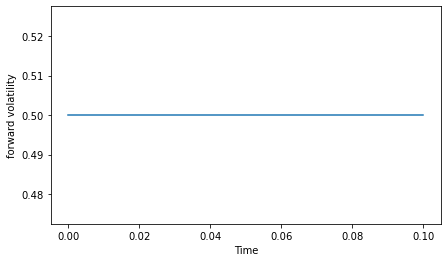

In [7]:
"""Time dependent Volatility"""
K_spot_vola = np.array([spot_price,200])
spot_vol = np.array(([volatility,volatility],[0.3,0.3]))
spot_vol_dates = np.array([0.1,T_max])
V = ForwardVariance(reference=t,maturities=spot_vol_dates,strikes=K_spot_vola,spot_volatility=spot_vol,strike_interp=spot_price)

plt.figure(figsize=(7,4))
time = V.T.tolist()
vola = V.forward_vol.tolist()
time.insert(0,V.T[0])
time.insert(0,0)
vola.insert(0,V.forward_vol[0])
vola.insert(0,V.forward_vol[0])
plt.step(time, vola)
plt.xlabel("Time")
plt.ylabel("forward volatility")
plt.show()

### Simulation

In [8]:
%%time
B_model = Black(variance=V, forward_curve=F)
kind=1
S_t = B_model.simulate(fixings=dates, Nsim=N_simulations, seed=8)
G_mean = gmean(S_t,axis=1)
forward_g_asian = spot_price*exp(interest_rate_asian(N_averages,r,volatility)*maturity)
X_t = G_mean/forward_g_asian
E_X = np.mean(X_t)
K_norm = 1
pay_normalized = Vanilla_PayOff(St=X_t,strike=K_norm, typo = kind) #ATM forward pricing

"""Calculating closed form"""
right = GA_Asian_option_closed_form(forward = F(maturity), strike= forward_g_asian, maturity=maturity, reference=t, zero_interest_rate = r, volatility=volatility, N_averages=N_averages, typo = kind)

Single Asset Simulation
CPU times: user 2.13 s, sys: 373 ms, total: 2.5 s
Wall time: 2.51 s


### Convergence Check

In [14]:
x, result, result_err = MC_Analisys(pay_normalized,N_block)
mean_price = result*D(maturity)*forward_g_asian
err_price = result_err*D(maturity)*forward_g_asian

#### In term of price

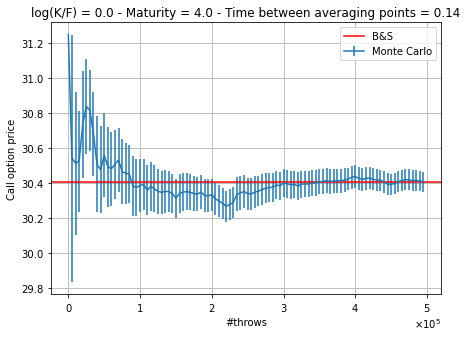

In [15]:
nu = dates[1]-dates[0]
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.axhline(y=right, color = 'red',linestyle='-',label = 'B&S')
plt.errorbar(x,mean_price,yerr=err_price,label = 'Monte Carlo')
plt.xlabel("#throws")
plt.title("log(K/F) = "+str(log(K_norm))+" - Maturity = "+str(maturity)+" - Time between averaging points = "+str(round(nu,2)))
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
    #plt.savefig('Graphs/European_call_option.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
    #plt.savefig('Graphs/European_put_option.pdf')
plt.show()

/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


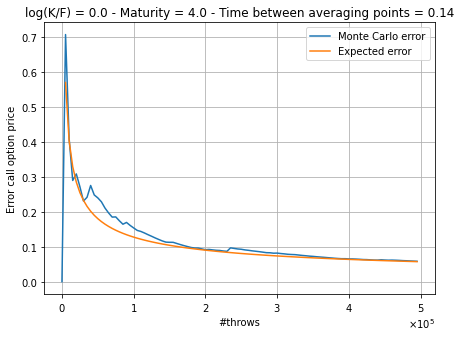

In [16]:
z = np.std(pay_normalized)*D(maturity)*forward_g_asian
y = np.sqrt(x)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(x,err_price, label = 'Monte Carlo error')
plt.plot(x,z/y, label = 'Expected error')
plt.xlabel("#throws")
plt.title("log(K/F) = "+str(log(K_norm))+" - Maturity = "+str(maturity)+" - Time between averaging points = "+str(round(nu,2)))
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
if kind==1:
    plt.ylabel('Error call option price')
    #plt.savefig('Graphs/Error_asian_call_option.pdf')
elif kind==-1:
    plt.ylabel('Error put option price')
   # plt.savefig('Graphs/Error_asian_put_option.pdf')
plt.show()

#### In term of implied volatility

In [12]:
imp_volatility_mean = np.zeros(N_block)
imp_volatility_plus = np.zeros(N_block)
imp_volatility_minus = np.zeros(N_block)
print("Calculating implied volatility")
for i in range (N_block):
    imp_volatility_mean[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i],E_X,1,maturity,kind)
    imp_volatility_plus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]+result_err[i],E_X,1,maturity,kind)
    imp_volatility_minus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]-result_err[i],E_X,1,maturity,kind)

print("Error analysis")    
y_lower = np.zeros(N_block)
y_upper = np.zeros(N_block)
for i in range(N_block):
    if(imp_volatility_minus[i]<imp_volatility_plus[i]):
        y_lower[i] = abs(imp_volatility_mean[i]-imp_volatility_minus[i])
        y_upper[i] = abs(imp_volatility_plus[i]-imp_volatility_mean[i])
    elif(imp_volatility_minus[i]>imp_volatility_plus[i]):
        y_lower[i] = abs(imp_volatility[i]-imp_volatility_plus[i])
        y_upper[i] = abs(imp_volatility_minus[i]-imp_volatility_mean[i])


Calculating implied volatility
Error analysis


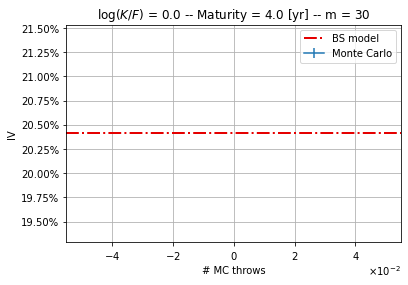

In [13]:
fig, ax = plt.subplots(1, 1)
plt.title(r"log$(K/F)$ = "+str(log(K_norm))+" -- Maturity = "+str(round(maturity,1))+' [yr] -- m = 30')
plt.errorbar(x,imp_volatility_mean,yerr=[y_lower,y_upper], label = "Monte Carlo")
plt.axhline(y=asian_vola, lw=2,c='xkcd:red',linestyle='-.',label = 'BS model') 
plt.xlabel("# MC throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.ylabel("IV")
plt.legend()
#plt.savefig('Asian_Option/Asian_convergence.pdf',bbox_inches='tight')

/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


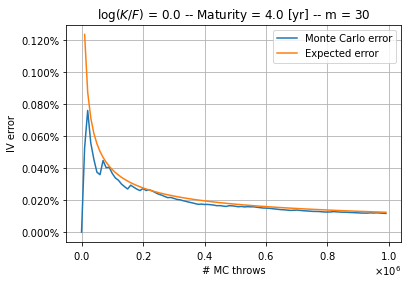

In [26]:
y = np.sqrt(x)
fig, ax = plt.subplots(1, 1)
plt.title(r"log$(K/F)$ = "+str(log(K_norm))+" -- Maturity = "+str(round(maturity,1))+' [yr] -- m = 30')
plt.plot(x,y_upper, label = 'Monte Carlo error')
plt.plot(x,(asian_vola+0.009)/y, label = 'Expected error')
plt.xlabel("# MC throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.xaxis.set_major_formatter(formatter)
plt.grid(True)
plt.ylabel("IV error")
plt.legend()
if kind==1:
    plt.ylabel('IV error')
   # plt.savefig('Graphs/Error_euro_call_option.pdf')
elif kind==-1:
    plt.ylabel('Error put option price')
    #plt.savefig('Graphs/Error_euro_put_option.pdf')
#plt.savefig('Asian_Option/Asian_convergence_error.pdf',bbox_inches='tight')
plt.show()

### Implied volatility in function of Log-moneyness log(K/F)

In [17]:
%%time
logmoneyness =np.arange(-10,11)*0.1
maturities = np.arange(1,31)*0.15
N_averages = 30
imp_volatility = np.zeros((len(logmoneyness),len(maturities)))
imp_volatility_plus = np.zeros((len(logmoneyness),len(maturities)))
imp_volatility_minus = np.zeros((len(logmoneyness),len(maturities)))
for i in range(len(maturities)):
    dates = np.linspace(0.,maturities[i],N_averages)
    S_t = B_model.simulate(fixings=dates, Nsim=N_simulations, seed=8)
    G_mean = gmean(S_t,axis=1)    
    for j in range(len(logmoneyness)):
        if logmoneyness[j]>=0.:
            kind =1
        elif logmoneyness[j]<0.:
            kind =-1
        K = np.exp(logmoneyness[j])
        forward = spot_price*exp(interest_rate_asian(N_averages,r,volatility)*maturities[i])
        X_t = G_mean/forward
        E = np.mean(X_t,axis=0)
        option = Vanilla_PayOff(St=X_t, strike=K,typo=kind)
        result, err_result = MC(option)
        imp_volatility[j][i] = lbr.implied_volatility_from_a_transformed_rational_guess(result,E,K,maturities[i],kind)
        imp_volatility_plus[j][i] = lbr.implied_volatility_from_a_transformed_rational_guess(result+err_result,E,K,maturities[i],kind)
        imp_volatility_minus[j][i] = lbr.implied_volatility_from_a_transformed_rational_guess(result-err_result,E,K,maturities[i],kind)
        
print("Saving_Files...")
#np.savetxt("Results/asian_norm_implied_volatility_mean_log.txt",imp_volatility)    #saving results
#np.savetxt("Results/asian_norm_implied_volatility_minus_log.txt",imp_volatility_minus)    #saving results
#np.savetxt("Results/asian_norm_implied_volatility_plus_log.txt",imp_volatility_plus)    #saving results
#np.savetxt("Results/asian_norm_moneyness_log.txt",logmoneyness)
#np.savetxt("Results/asian_norm_maturities_log.txt",maturities)
print("COMPLETED")

Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Single Asset Simulation
Saving_Files...
COMPLETED
CPU times: user 1min 10s, sys: 4.24 s, total: 1min 15s
Wall time: 1min 15s


In [18]:
y_lower = np.zeros((len(logmoneyness),len(maturities)))
y_upper = np.zeros((len(logmoneyness),len(maturities)))
for i in range(len(logmoneyness)):
     for j in range(len(maturities)):
            if(imp_volatility_minus[i][j]<imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_minus[i][j])
                y_upper[i][j] = abs(imp_volatility_plus[i][j]-imp_volatility[i][j])
            elif(imp_volatility_minus[i][j]>imp_volatility_plus[i][j]):
                y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_plus[i][j])
                y_upper[i][j] = abs(imp_volatility_minus[i][j]-imp_volatility[i][j])


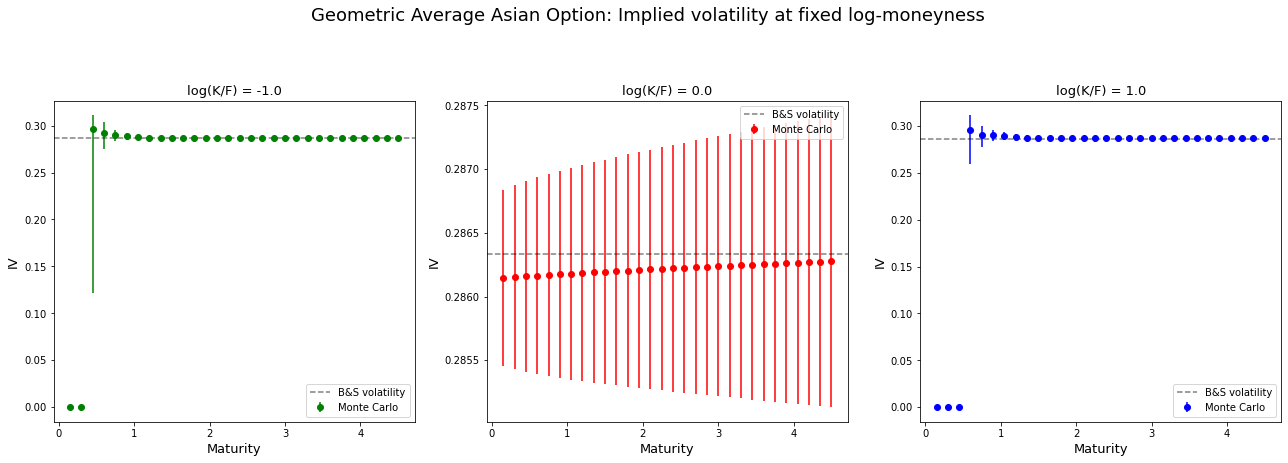

In [20]:
plt.figure(figsize=(22,13))
plt.suptitle("Geometric Average Asian Option: Implied volatility at fixed log-moneyness",fontsize=18)
n_sigma = 2  #how many sigma for the errorbars
i=0
num = [0] 
c=2
plt.subplot(2,3,1)
err_lower = n_sigma*y_lower[num[i]]
err_upper = n_sigma*y_upper[num[i]]
plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "green",label="Monte Carlo")
plt.title("log(K/F) = "+str(round(logmoneyness[num[i]],c)),fontsize=13)
plt.axhline(y=asian_vola, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity",fontsize=13)
plt.ylabel("IV",fontsize=13)
#plt.ylim(0.038,0.12)  
plt.legend()

num = [10] 
plt.subplot(2,3,2)
err_lower = n_sigma*y_lower[num[i]]
err_upper = n_sigma*y_upper[num[i]]
plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "red",label="Monte Carlo")
plt.title("log(K/F) = "+str(round(logmoneyness[num[i]],c)),fontsize=13)
plt.axhline(y=asian_vola, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.legend()

num = [20]
plt.subplot(2,3,3)
err_lower = n_sigma*y_lower[num[i]]
err_upper = n_sigma*y_upper[num[i]]
plt.errorbar(maturities,imp_volatility[num[i]],yerr=[err_lower,err_upper],fmt="o",color = "blue",label="Monte Carlo")
plt.title("log(K/F) = "+str(round(logmoneyness[num[i]],c)),fontsize=13)
plt.axhline(y=asian_vola, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')
plt.xlabel("Maturity",fontsize=13)
plt.ylabel("IV",fontsize=13)
#plt.ylim(0.04,0.12)
plt.legend()
plt.show()

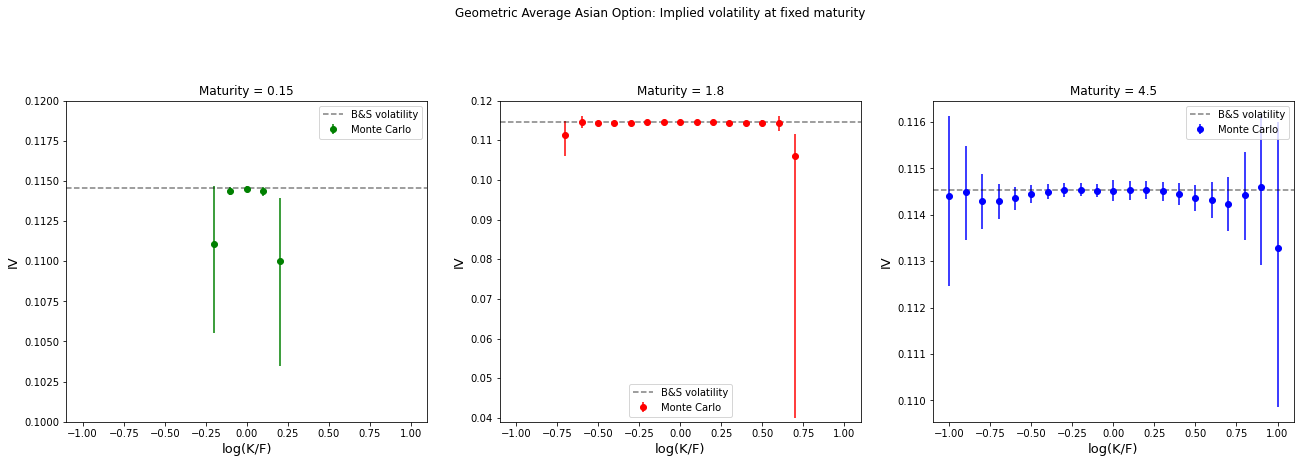

In [15]:
plt.figure(figsize=(22,13))
plt.suptitle("Geometric Average Asian Option: Implied volatility at fixed maturity")
n_sigma = 2   #how many sigma for the errorbars

num = [0] 
c=2
plt.subplot(2,3,1)
err_lower = n_sigma*y_lower.T[num[i]]
err_upper = n_sigma*y_upper.T[num[i]]
plt.errorbar(logmoneyness,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="green",label="Monte Carlo")
plt.axhline(y=asian_vola, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("log(K/F)",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.title("Maturity = "+str(round(maturities[num[i]],c)))
plt.ylim(0.10,0.12)
plt.legend()

num = [11] 
plt.subplot(2,3,2)
err_lower = n_sigma*y_lower.T[num[i]]
err_upper = n_sigma*y_upper.T[num[i]]
plt.errorbar(logmoneyness,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="red",label="Monte Carlo")
plt.axhline(y=asian_vola, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("log(K/F)",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.title("Maturity = "+str(round(maturities[num[i]],c)))
plt.ylim(0.039,0.12)
plt.legend()

num = [29]
plt.subplot(2,3,3)
err_lower = n_sigma*y_lower.T[num[i]]
err_upper = n_sigma*y_upper.T[num[i]]
plt.errorbar(logmoneyness,imp_volatility.T[num[i]],yerr=[err_lower,err_upper],fmt="o",color="blue",label="Monte Carlo")
plt.axhline(y=asian_vola, color = 'black',alpha = 0.5,linestyle='--',label = 'B&S volatility')  
plt.xlabel("log(K/F)",fontsize=13)
plt.ylabel("IV",fontsize=13)
plt.title("Maturity = "+str(round(maturities[num[i]],c)))
plt.legend()
plt.show()

## OTHER RESULTS IN TERM OF PRICE

In [ ]:
x = np.arange(1,21)*10
media = np.zeros(len(x))
errore = np.zeros(len(x))
for i in range(len(x)):
    fixings = np.linspace(ref,maturity,x[i])
    S_t = B_model.simulate(fixings=fixings, Nsim=1e6, seed=2)
    G_mean = gmean(S_t,axis=1)
    pay = Vanilla_PayOff(St=G_mean,strike=strike, typo = kind)*D(maturity)
    mean, err = MC(pay)
    media[i] = mean
    errore[i] = err
   
    
#np.savetxt("Results/Asian_frequence.txt",media)
#np.savetxt("Results/Asian_frequence_err.txt",errore)
#np.savetxt("Results/frequence_asian.txt",x)

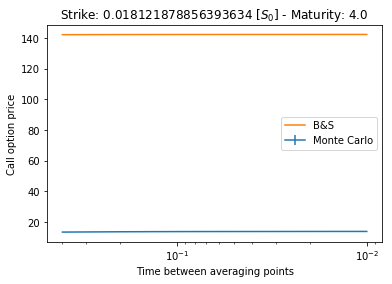

In [23]:
x = np.loadtxt("Results/frequence_asian.txt")
media = np.loadtxt("Results/Asian_frequence.txt")
errore = np.loadtxt("Results/Asian_frequence_err.txt")
nu = maturity/x
closed = GA_Asian_option_closed_form(forward = F(maturity), strike= K, maturity=maturity, reference=t, zero_interest_rate = r, volatility=volatility, N_averages=x, typo = kind)
plt.errorbar(nu,media,yerr=errore, label = 'Monte Carlo')
plt.plot(nu,closed,label='B&S')
plt.xlabel('Time between averaging points')
plt.gca().invert_xaxis()
plt.title("Strike: "+str(K/spot_price)+" [$S_0$] - Maturity: "+str(maturity))
plt.xscale("Log")
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
 #   plt.savefig('Graphs/Asian_call_number.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
  #  plt.savefig('Graphs/Asian_put_number.pdf')
plt.show()


In [ ]:
x = np.arange(1,51)*(spot_price*0.25)
m = 100  #number of means before maturity
maturity = 4.0
fixings = np.linspace(reference,maturity,m)
media = np.zeros(len(x))
errore = np.zeros(len(x))
S_t = B_model.simulate(fixings=fixings, Nsim=1e6, seed=2)
G_mean = gmean(S_t,axis=1)
for i in range(len(x)):
    pay = Vanilla_PayOff(St=G_mean,strike=x[i], typo = kind)*D(maturity)
    mean, err = MC(pay)
    media[i] = mean
    errore[i] = err

#np.savetxt("Results/Asian_strike.txt",media)
#np.savetxt("Results/Asian_strike_err.txt",errore)
#np.savetxt("Results/strike_asian.txt",x)

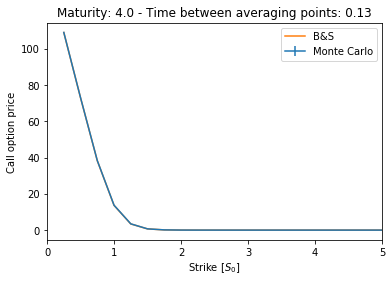

In [24]:
x = np.loadtxt("Results/strike_asian.txt")
media = np.loadtxt("Results/Asian_strike.txt")
errore = np.loadtxt("Results/Asian_strike_err.txt")
closed = GA_Asian_option_closed_form(forward = F(maturity), strike= x, maturity=maturity, reference=t, zero_interest_rate = r, volatility=volatility, N_averages=N_averages, typo = kind)
plt.errorbar(x/spot_price,media,yerr=errore, label = 'Monte Carlo')
plt.plot(x/spot_price,closed,label='B&S')
plt.xlabel('Strike [$S_0$]')
plt.title("Maturity: "+str(maturity)+" - Time between averaging points: "+str(round(maturity/N_averages,2)))
plt.xlim(0,5)
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
   # plt.savefig('Graphs/Asian_call_strike.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
    #plt.savefig('Graphs/Asian_put_strike.pdf')
plt.show()


In [ ]:
x = np.arange(1,41)*0.25
media = np.zeros(len(x))
errore = np.zeros(len(x))
for i in range(len(x)):
    fixings = np.linspace(reference,x[i],m)
    S_t = B_model.simulate(fixings=fixings, Nsim=1e5, seed=2)
    G_mean = gmean(S_t,axis=1)
    pay = Vanilla_PayOff(St=G_mean,strike=strike, typo = kind)*D(x[i])
    mean, err = MC(pay)
    media[i] = mean
    errore[i] = err
    
#np.savetxt("Results/Asian_maturity.txt",media)
#np.savetxt("Results/Asian_maturity_err.txt",errore)
#np.savetxt("Results/maturity_asian.txt",x)

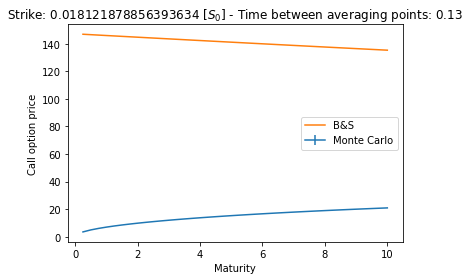

In [25]:
x = np.loadtxt("Results/maturity_asian.txt")
media = np.loadtxt("Results/Asian_maturity.txt")
errore = np.loadtxt("Results/Asian_maturity_err.txt")
closed = GA_Asian_option_closed_form(forward = F(x), strike= K, maturity=x, reference=t, zero_interest_rate = r, volatility=volatility, N_averages=N_averages, typo = kind)
plt.errorbar(x,media,yerr=errore, label = 'Monte Carlo')
plt.plot(x,closed,label='B&S')
plt.xlabel('Maturity')
plt.title("Strike: "+str(K/spot_price)+" [$S_0$] - Time between averaging points: "+str(round(maturity/N_averages,2)))
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
  #  plt.savefig('Graphs/Asian_call_maturity.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
   # plt.savefig('Graphs/Asian_put_maturity.pdf')
plt.show()

### Asian VS European

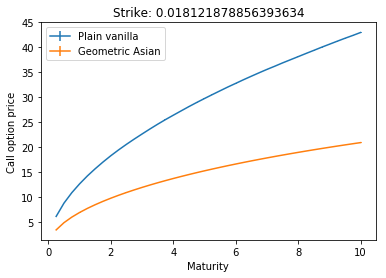

In [26]:
x = np.loadtxt("Results/maturity_asian.txt")
media = np.loadtxt("Results/Asian_maturity.txt")
errore = np.loadtxt("Results/Asian_maturity_err.txt")
euro = np.loadtxt("Results/European_call_maturity.txt")
euro_err = np.loadtxt("Results/European_call_err_maturity.txt")
plt.errorbar(x,euro,yerr=euro_err, label = 'Plain vanilla')
plt.errorbar(x,media,yerr=errore, label = 'Geometric Asian')
plt.xlabel('Maturity')
plt.title("Strike: "+str(K/spot_price))
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
    #plt.savefig('Graphs/Asian_euro_call_maturity.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
   # plt.savefig('Graphs/Asian_euro_put_maturity.pdf')
plt.show()

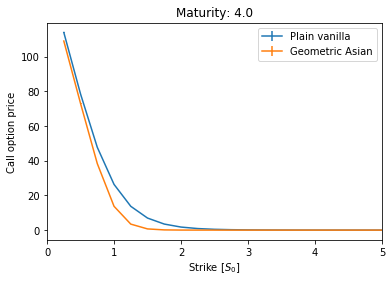

In [27]:
x = np.loadtxt("Results/strike_asian.txt")
media = np.loadtxt("Results/Asian_strike.txt")
errore = np.loadtxt("Results/Asian_strike_err.txt")
euro = np.loadtxt("Results/European_call_strike.txt")
euro_err = np.loadtxt("Results/European_call_err_strike.txt")

plt.errorbar(x/spot_price,euro,yerr=euro_err, label = 'Plain vanilla')
plt.errorbar(x/spot_price,media,yerr=errore, label = 'Geometric Asian')
plt.xlabel('Strike [$S_0$]')
plt.title("Maturity: "+str(maturity))
plt.xlim(0,5)
plt.legend()
if kind==1:
    plt.ylabel('Call option price')
    #plt.savefig('Graphs/Asian_euro_call_strike.pdf')
elif kind==-1:
    plt.ylabel('Put option price')
    #plt.savefig('Graphs/Asian_euro_put_strike.pdf')
plt.show()